# Transform DICOM metadata

* Download DICOM metadata you want to transform
* Download ODBC Driver 18 from web <https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/install-microsoft-odbc-driver-sql-server-macos?view=sql-server-ver16>
* OMOP CDM instance with the connection string and authentication information. If your database access limits IP addresses, make sure to add your IP address before running the connection strings.
* OMOP CDM Person table should be updated with demographic information, if available, before running this code. If not, you can upload the Person table using DICOM Patient metadata information.
* Install SQL processing package, i.e., pyodbc.

In [2]:
# Load your DICOM metadata file
import pandas as pd

flat_metadata_df = pd.read_pickle('./files/ADNI/all_metadata_long.pkl')

In [4]:
# Import concept table from the SQL database
# *** run this after uploading DICOM custom concepts ***

import psycopg2

# conncet to your database 
conn = psycopg2.connect(
    database="",
    user="",
    password="",
    host="",
    port="",
    connect_timeout = 6000
)
 
cursor = conn.cursor()

sql = "select * from dbo.concept"
concept_df = pd.read_sql_query(sql, conn)
concept_df.head()

# close the cursor and connection
cursor.close()
conn.close()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_95529/3497550908.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  concept_df = pd.read_sql_query(sql, conn)


In [5]:
# Get OMOP concepts for DICOM attributes
metadata_omop = flat_metadata_df.merge(concept_df[concept_df['vocabulary_id']=="DICOM"][['concept_id', 'concept_code', 'concept_name']], how = 'left', left_on = 'Tag', right_on = 'concept_code')
print(metadata_omop.shape)
metadata_omop.head()

(691224, 8)


,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_code,concept_name
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,CS,ISO_IR 100,2.128000e+09,00080005,Specific Character Set
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,CS,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D",2.128000e+09,00080008,Image Type
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,TM,132059.900000,2.128000e+09,00080013,Instance Creation Time
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080016,UI,1.2.840.10008.5.1.4.1.1.4,NaN,NaN,NaN
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080018,UI,2.16.124.113543.6006.99.02372564384492529391,NaN,NaN,NaN


In [6]:
# update concept_id data type to int
metadata_omop['concept_id'] = metadata_omop['concept_id'].astype('Int64')

In [7]:
# inspect number of DICOM metadata elements that will not be added to OMOP CDM
metadata_omop[~metadata_omop['concept_id'].isna()].shape #296396 ~43%

(296396, 8)

## Image Occurrence Table Staging

In [35]:
# inspect tags needed for imaging extension tables
tags_for_columns = ["00080020", "00100020", "00080060", "00180015"]
metadata_omop[metadata_omop['Tag'].isin(tags_for_columns)].groupby('Tag')['SeriesUID'].nunique()

Tag
00080020    4756
00080060    4756
00100020    4756
00180015    3987
Name: SeriesUID, dtype: int64

In [25]:
# boby part examined: 769 series missing this value
metadata_omop[metadata_omop['Tag']=="00180015"].groupby('Value')['SeriesUID'].count()

Value
BRAIN        3484
HEAD          403
HEAD_NECK     100
Name: SeriesUID, dtype: int64

In [30]:
# study date
metadata_omop[metadata_omop['Tag']=="00080020"].head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id,concept_code,concept_name
5,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080020,DA,20171204,2128000017,00080020,Study Date
104,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,00080020,DA,20171204,2128000017,00080020,Study Date
203,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06964874624365474765,00080020,DA,20171204,2128000017,00080020,Study Date
311,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.07300304364963768908,00080020,DA,20171204,2128000017,00080020,Study Date
411,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.08097639857522452001,00080020,DA,20171204,2128000017,00080020,Study Date


In [47]:
# modality
metadata_omop[metadata_omop['Tag']=="00080060"].groupby('Value')['SeriesUID'].count()

Value
MR    4756
Name: SeriesUID, dtype: int64

In [42]:
df_subset = metadata_omop[metadata_omop['Tag'].isin(tags_for_columns)][['StudyUID', 'SeriesUID', 'Tag', 'Value']]
df_subset = df_subset.pivot(index=['StudyUID', 'SeriesUID'], columns='Tag', values='Value').reset_index()
df_subset.columns.name = None
print(df_subset.shape)
df_subset.head()

(4756, 6)


,StudyUID,SeriesUID,00080020,00080060,00100020,00180015
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,20190709,MR,003_S_6260,BRAIN
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,20190709,MR,003_S_6260,BRAIN
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,20190709,MR,003_S_6260,BRAIN
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,20190709,MR,003_S_6260,BRAIN
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,20190709,MR,003_S_6260,BRAIN


In [44]:
# Load person_id from registry id map table (created using ADNI demographic file)
df_id = pd.read_csv('./files/OMOP CDM Staging/registry_idmap.csv')
print(df_id.shape)
df_id.head()

(4152, 3)


,source_id,person_id,source_name
0,011_S_0002,1,ADNI
1,022_S_0001,2,ADNI
2,011_S_0003,3,ADNI
3,022_S_0004,4,ADNI
4,011_S_0005,5,ADNI


In [45]:
df_subset = df_subset.merge(df_id[['source_id', 'person_id']], how = 'left', left_on = '00100020', right_on = 'source_id')
df_subset.head()

,StudyUID,SeriesUID,00080020,00080060,00100020,00180015,source_id,person_id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339


In [61]:
# use Athena to get standard concept ids
df_subset['anatomic_site_concept_id'] = 4119359 # since the values are too varied and some are empty, we will use the most popular entry, BRAIN
df_subset['modality_concept_id'] = 4013636 # MR
df_subset['image_occurrence_date'] = pd.to_datetime(df_subset['00080020'])
df_subset['wadors_uri'] = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2/studies/' + df_subset['StudyUID'] + '/series/' + df_subset['SeriesUID']
df_subset['visit_type_concept_id'] = 32817 #EHR
df_subset['visit_concept_id'] = 9202 #outpatient visit
print(df_subset.shape)
df_subset.head()

(4756, 17)


,StudyUID,SeriesUID,00080020,00080060,00100020,00180015,source_id,person_id,anatomic_site_concept_id,modality_concept_id,image_occurrence_date,wadors_uri,image_occurrence_id,procedure_occurrence_id,visit_occurrence_id,visit_type_concept_id,visit_concept_id
0,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.01296719744744407133,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,1,1,1,32817,9202
1,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.02054130675780820610,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,2,2,2,32817,9202
2,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.04611770930445736334,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,3,3,3,32817,9202
3,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.0701056875880124301,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,4,4,4,32817,9202
4,2.16.124.113543.6006.99.01047543405701085685,2.16.124.113543.6006.99.1284958151862260961,20190709,MR,003_S_6260,BRAIN,003_S_6260,3339,4119359,4013636,2019-07-09,https://imgextpoc-adnidicom.dicom.azurehealthc...,5,5,5,32817,9202


In [63]:
# set IDs
df_subset['image_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))
df_subset['procedure_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))
df_subset['visit_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))

In [64]:
df_subset.to_pickle('./files/OMOP CDM Staging/image_occurrence_staging_v2.pkl')

## Prepare other tags

In [9]:
# inspect the most popular tags that will be added to the OMOP CDM
metadata_omop_tag_counts = metadata_omop[~metadata_omop['concept_id'].isna()][['concept_name', 'vr']].value_counts()
metadata_omop_tag_counts[:20]

concept_name                vr
Photometric Interpretation  CS    4756
Bits Stored                 US    4756
Series Number               IS    4756
Series Date                 DA    4756
Study Date                  DA    4756
Study Time                  TM    4756
Content Time                TM    4756
Content Date                DA    4756
High Bit                    US    4756
Columns                     US    4756
Instance Number             IS    4756
Samples per Pixel           US    4756
MR Acquisition Type         CS    4756
Image Type                  CS    4756
Bits Allocated              US    4756
Modality                    CS    4756
Patient Position            CS    4756
Pixel Representation        US    4756
Rows                        US    4756
Series Time                 TM    4756
Name: count, dtype: int64

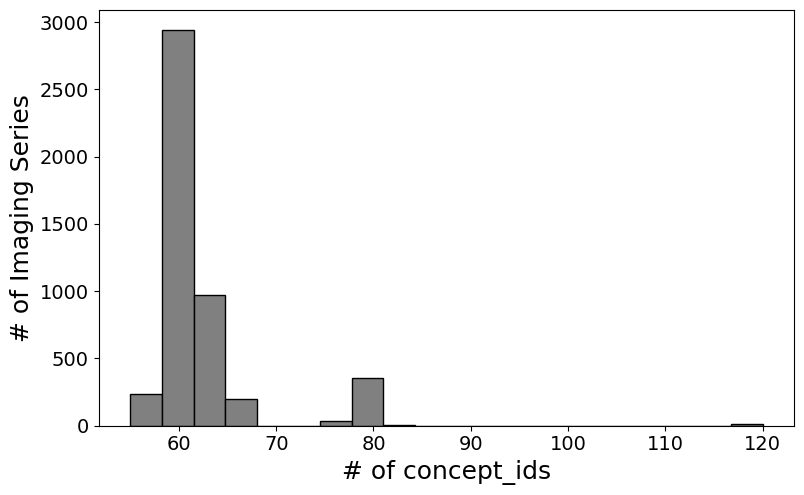

In [10]:
# Create a histogram of number of metadata elements per series
import matplotlib.pyplot as plt

# Filter out rows where 'concept_id' is NaN
filtered_metadata = metadata_omop[~metadata_omop['concept_id'].isna()]

# Get the number of concept_ids per SeriesUID
concepts_per_series = filtered_metadata['SeriesUID'].value_counts()

# Plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(concepts_per_series, bins=20, edgecolor='black', color='grey')
plt.xlabel('# of concept_ids', fontsize=18)
plt.ylabel('# of Imaging Series', fontsize=18)
plt.tight_layout()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

In [11]:
# for CS and SQ type Attributes, we need to map value as concept id by joining value to concept table
filtered_metadata_value_concepts = filtered_metadata[filtered_metadata['vr'].isin(['SQ', 'CS'])].merge(concept_df[concept_df['vocabulary_id']=="DICOM"][['concept_id','concept_name', 'concept_class_id', 'concept_code']],
                                                                    how = 'inner', left_on = 'Value', right_on = 'concept_code')

In [12]:
print(filtered_metadata_value_concepts.shape)
filtered_metadata_value_concepts.head()

(18852, 12)


,StudyUID,SeriesUID,Tag,vr,Value,concept_id_x,concept_code_x,concept_name_x,concept_id_y,concept_name_y,concept_class_id,concept_code_y
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080060,CS,MR,2128000035,00080060,Modality,2128007813,Magnetic Resonance,DICOM Value Sets,MR
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00100040,CS,F,2128000110,00100040,Patient's Sex,2128008067,Female,DICOM Value Sets,F
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180015,CS,BRAIN,2128000419,00180015,Body Part Examined,2128021455,Brain,DICOM Value Sets,BRAIN
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00185100,CS,HFS,2128000656,00185100,Patient Position,2128015375,Head First-Supine,DICOM Value Sets,HFS
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06263494736769400825,00080060,CS,MR,2128000035,00080060,Modality,2128007813,Magnetic Resonance,DICOM Value Sets,MR


In [14]:
# inspect what was identified
print(filtered_metadata_value_concepts['vr'].unique())
filtered_metadata_value_concepts['Value'].unique()

['CS']


array(['MR', 'F', 'BRAIN', 'HFS', 'M', 'YES', '00', 'IDENTITY', 'FC',
       'MP', 'NO', 'HEAD', 'U', 'RF'], dtype=object)

In [15]:
# inspect values with unmatched OMOP concepts
omop_value_not_found_cs = filtered_metadata[(filtered_metadata['vr']=='CS') & 
                                            (~filtered_metadata['Value'].isin(['MR', 'F', 'BRAIN', 'HFS', 'M', 'YES', '00', 'IDENTITY', 'FC','MP', 'NO', 'HEAD', 'U', 'RF', 'T2', 'T1']))
                                            ][['Tag', 'concept_name', 'Value']].drop_duplicates().reset_index(drop=True)
print(omop_value_not_found_cs.shape)
omop_value_not_found_cs.head()

(173, 3)


,Tag,concept_name,Value
0,00080005,Specific Character Set,ISO_IR 100
1,00080008,Image Type,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D"
2,00180020,Scanning Sequence,"GR, IR"
3,00180021,Sequence Variant,"SK, SP, MP"
4,00180022,Scan Options,IR


In [16]:
omop_value_not_found_cs['Tag'].nunique()

57

In [17]:
# potential reaons for unmatch
# DICOM metadata source has none or null values
# DICOM metadata source has multiple values
# DICOM metadata source has unmatching single values
print("Value missing:", omop_value_not_found_cs[(omop_value_not_found_cs['Value'].isna()) | (omop_value_not_found_cs['Value']=="NONE")].shape)
print("Multiple values:",omop_value_not_found_cs[(~omop_value_not_found_cs['Value'].isna()) & (omop_value_not_found_cs['Value'].str.contains(','))].shape)
# 173-28-82=63 unmatching single values

Value missing: (28, 3)
Multiple values: (82, 3)


In [18]:
filtered_metadata_SQ = filtered_metadata[filtered_metadata['vr']=='SQ'].groupby(['Tag', 'concept_name', 'Value']).agg(counts=('Value', len)).reset_index()
filtered_metadata_SQ 

,Tag,concept_name,Value,counts
0,00081032,Procedure Code Sequence,"{'0008010B': {'vr': 'CS', 'Value': ['N']}}",406
1,00081032,Procedure Code Sequence,{},1362
2,00082218,Anatomic Region Sequence,"{'00080100': {'vr': 'SH', 'Value': ['T-A0100']...",282
3,00082218,Anatomic Region Sequence,"{'00080100': {'vr': 'SH', 'Value': ['T-D1100']...",17
4,00120064,De-identification Method Code Sequence,"{}, {}, {}, {}, {}, {}, {}",70
...,...,...,...,...
375,00409096,Real World Value Mapping Sequence,"{'00409224': {'vr': 'FD', 'Value': [0]}, '0040...",1
376,00409096,Real World Value Mapping Sequence,"{'00409224': {'vr': 'FD', 'Value': [0]}, '0040...",1
377,00409096,Real World Value Mapping Sequence,"{'00409224': {'vr': 'FD', 'Value': [0]}, '0040...",1
378,00409096,Real World Value Mapping Sequence,"{'00409224': {'vr': 'FD', 'Value': [0]}, '0040...",1


In [23]:
# Add only CS codes that matched using Value and Concept_code
new_image_features_cs = filtered_metadata[filtered_metadata['vr'].isin(['CS'])].merge(concept_df[concept_df['vocabulary_id']=="DICOM"][['concept_id','concept_name', 'concept_class_id', 'concept_code']],
                                                                    how = 'left', left_on = 'Value', right_on = 'concept_code') 
print(new_image_features_cs.shape)
new_image_features_cs.head()

(70312, 12)


,StudyUID,SeriesUID,Tag,vr,Value,concept_id_x,concept_code_x,concept_name_x,concept_id_y,concept_name_y,concept_class_id,concept_code_y
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,CS,ISO_IR 100,2128000011,00080005,Specific Character Set,NaN,NaN,NaN,NaN
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,CS,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D",2128000012,00080008,Image Type,NaN,NaN,NaN,NaN
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080060,CS,MR,2128000035,00080060,Modality,2.128008e+09,Magnetic Resonance,DICOM Value Sets,MR
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00100040,CS,F,2128000110,00100040,Patient's Sex,2.128008e+09,Female,DICOM Value Sets,F
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180015,CS,BRAIN,2128000419,00180015,Body Part Examined,2.128021e+09,Brain,DICOM Value Sets,BRAIN


In [21]:
# non-CS values
new_image_features_non_cs = filtered_metadata[~filtered_metadata['vr'].isin(['CS', 'SQ'])]
new_image_features_non_cs = new_image_features_non_cs.rename(columns={'concept_id': 'concept_id_x',
                                                                      'concept_name': 'concept_name_x',
                                                                      'concept_code': 'concept_code_x'})
print(new_image_features_non_cs.shape)
new_image_features_non_cs.head()

(220851, 8)


,StudyUID,SeriesUID,Tag,vr,Value,concept_id_x,concept_code_x,concept_name_x
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080013,TM,132059.900000,2128000014,00080013,Instance Creation Time
5,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080020,DA,20171204,2128000017,00080020,Study Date
6,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080021,DA,20171204,2128000018,00080021,Series Date
7,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080022,DA,20171204,2128000019,00080022,Acquisition Date
8,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080023,DA,20171204,2128000020,00080023,Content Date


In [22]:
new_image_features = pd.concat([new_image_features_cs, new_image_features_non_cs])
new_image_features['concept_id_y'] = new_image_features['concept_id_y'].astype('Int64')
print(new_image_features.shape)
new_image_features

(291163, 12)


,StudyUID,SeriesUID,Tag,vr,Value,concept_id_x,concept_code_x,concept_name_x,concept_id_y,concept_name_y,concept_class_id,concept_code_y
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,CS,ISO_IR 100,2128000011,00080005,Specific Character Set,<NA>,NaN,NaN,NaN
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,CS,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D",2128000012,00080008,Image Type,<NA>,NaN,NaN,NaN
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080060,CS,MR,2128000035,00080060,Modality,2128007813,Magnetic Resonance,DICOM Value Sets,MR
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00100040,CS,F,2128000110,00100040,Patient's Sex,2128008067,Female,DICOM Value Sets,F
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180015,CS,BRAIN,2128000419,00180015,Body Part Examined,2128021455,Brain,DICOM Value Sets,BRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...
691213,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281050,DS,-126,2128001392,00281050,Window Center,<NA>,NaN,NaN,NaN
691214,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281051,DS,5311,2128001393,00281051,Window Width,<NA>,NaN,NaN,NaN
691215,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281052,DS,-4096,2128001394,00281052,Rescale Intercept,<NA>,NaN,NaN,NaN
691216,2.16.124.113543.6006.99.9223169425485824208,2.16.124.113543.6006.99.640768751323050122,00281053,DS,2.000244140625,2128001395,00281053,Rescale Slope,<NA>,NaN,NaN,NaN


In [55]:
new_image_features = new_image_features.merge(df_subset[['image_occurrence_id', 'person_id', 'SeriesUID', 'image_occurrence_date', 'anatomic_site_concept_id']], 
                         how = 'left', on = 'SeriesUID')

In [56]:
new_image_features['image_feature_event_field_id'] = 1147330
new_image_features['image_feature_event_type_id'] = 32817
new_image_features['image_feature_event_id'] = range(1, len(new_image_features)+1)
new_image_features.head()

,StudyUID,SeriesUID,Tag,vr,Value,concept_id_x,concept_code_x,concept_name_x,concept_id_y,concept_name_y,concept_class_id,concept_code_y,image_occurrence_id,person_id,image_occurrence_date,anatomic_site_concept_id,image_feature_event_field_id,image_feature_event_type_id,image_feature_event_id
0,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080005,CS,ISO_IR 100,2128000011,00080005,Specific Character Set,<NA>,NaN,NaN,NaN,10,2161,2017-12-04,4119359,1147330,32817,1
1,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080008,CS,"ORIGINAL, PRIMARY, M, NORM, DIS3D, DIS2D",2128000012,00080008,Image Type,<NA>,NaN,NaN,NaN,10,2161,2017-12-04,4119359,1147330,32817,2
2,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00080060,CS,MR,2128000035,00080060,Modality,2128007813,Magnetic Resonance,DICOM Value Sets,MR,10,2161,2017-12-04,4119359,1147330,32817,3
3,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00100040,CS,F,2128000110,00100040,Patient's Sex,2128008067,Female,DICOM Value Sets,F,10,2161,2017-12-04,4119359,1147330,32817,4
4,2.16.124.113543.6006.99.01060096421826160662,2.16.124.113543.6006.99.06083117774660962009,00180015,CS,BRAIN,2128000419,00180015,Body Part Examined,2128021455,Brain,DICOM Value Sets,BRAIN,10,2161,2017-12-04,4119359,1147330,32817,5


In [57]:
new_image_features['value_as_number'] = new_image_features.apply(lambda row: row['Value'] if row['vr'] != 'CS' else None, axis=1)
new_image_features['measurement_source_value'] = new_image_features['Value'].astype(str).str[:50]
new_image_features = new_image_features.where(pd.notnull(new_image_features), None)

In [58]:
new_image_features.columns

Index(['StudyUID', 'SeriesUID', 'Tag', 'vr', 'Value', 'concept_id_x',
       'concept_code_x', 'concept_name_x', 'concept_id_y', 'concept_name_y',
       'concept_class_id', 'concept_code_y', 'image_occurrence_id',
       'person_id', 'image_occurrence_date', 'anatomic_site_concept_id',
       'image_feature_event_field_id', 'image_feature_event_type_id',
       'image_feature_event_id', 'value_as_number',
       'measurement_source_value'],
      dtype='object')

In [59]:
new_image_features['value_as_number'] = pd.to_numeric(new_image_features['Value'], errors='coerce')

In [ ]:
new_image_features.to_pickle('./files/ADNI/image_series_metadata_v2.pkl')